In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer, f1_score, confusion_matrix, plot_confusion_matrix
import pickle

In [3]:
df = pd.read_csv("../data/nfip_claims_ML.csv")

In [4]:
df.columns

Index(['Unnamed: 0', 'basementEnclosureCrawlspace', 'condominiumIndicator',
       'policyCount', 'countyCode', 'elevatedBuildingIndicator',
       'elevationCertificateIndicator', 'latitude', 'longitude',
       'locationOfContents', 'numberOfFloorsInTheInsuredBuilding',
       'nonProfitIndicator', 'obstructionType', 'occupancyType',
       'amountPaidOnBuildingClaim', 'amountPaidOnContentsClaim',
       'amountPaidOnIncreasedCostOfComplianceClaim',
       'postFIRMConstructionIndicator', 'rateMethod', 'state',
       'totalBuildingInsuranceCoverage', 'totalContentsInsuranceCoverage',
       'yearOfLoss', 'reportedZipcode', 'primaryResidence',
       'totalinsurancecoverage', 'amountPaidonTotalClaim', 'new_elev_diff',
       'floodzone_code', 'MonthOfLosss', 'BuildingsConstructionYear',
       'LossRatio', 'claim_segmentation'],
      dtype='object')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head()

,Unnamed: 0,basementEnclosureCrawlspace,condominiumIndicator,policyCount,countyCode,elevatedBuildingIndicator,elevationCertificateIndicator,latitude,longitude,locationOfContents,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,reportedZipcode,primaryResidence,totalinsurancecoverage,amountPaidonTotalClaim,new_elev_diff,floodzone_code,MonthOfLosss,BuildingsConstructionYear,LossRatio,claim_segmentation
0,0,1,N,1,24033,0,0,38,-77,0,3,0,999,1,0,0,0,0.0,7,MD,100000,40000,2007,20745,1.0,140000,0,0,X,1,1953,0.000000,0
1,1,0,N,1,30009,1,0,45,-109,0,2,0,50,1,593,0,0,0.0,1,MT,150000,0,2011,59068,1.0,150000,593,0,A,7,1975,0.003953,1
2,2,0,N,1,48201,0,3,29,-95,0,2,0,10,1,0,0,0,1.0,1,TX,25000,25000,2001,77025,1.0,50000,0,0,A,6,1983,0.000000,0
3,3,0,N,1,12103,1,0,27,-82,0,2,0,10,1,0,0,0,0.0,1,FL,150000,35000,1996,33702,1.0,185000,0,-1,A,10,1969,0.000000,0
4,4,0,N,1,24029,1,0,39,-76,0,2,0,10,1,31311,4329,0,0.0,1,MD,75000,10000,2003,21620,0.0,85000,35640,0,A,9,1980,0.419294,1


In [7]:
df.drop(["amountPaidonTotalClaim", "yearOfLoss", "Unnamed: 0", "LossRatio", "amountPaidOnBuildingClaim", "amountPaidOnContentsClaim", "amountPaidOnIncreasedCostOfComplianceClaim", "latitude", "longitude", "countyCode"], inplace=True, axis=1)
df.claim_segmentation = [1 if x==0 else 0 for x in df.claim_segmentation] # keep reportedZip # predict tghe 

In [7]:
#df = pd.get_dummies(df, drop_first=True)
#df.head()

In [11]:
df.to_csv("../data/claims_dummied.csv", index=False)

In [12]:
df.head()

,basementEnclosureCrawlspace,condominiumIndicator,policyCount,elevatedBuildingIndicator,elevationCertificateIndicator,locationOfContents,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,postFIRMConstructionIndicator,rateMethod,state,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,reportedZipcode,primaryResidence,totalinsurancecoverage,new_elev_diff,floodzone_code,MonthOfLosss,BuildingsConstructionYear,claim_segmentation
0,1,N,1,0,0,0,3,0,999,1,0.0,7,MD,100000,40000,20745,1.0,140000,0,X,1,1953,1
1,0,N,1,1,0,0,2,0,50,1,0.0,1,MT,150000,0,59068,1.0,150000,0,A,7,1975,0
2,0,N,1,0,3,0,2,0,10,1,1.0,1,TX,25000,25000,77025,1.0,50000,0,A,6,1983,1
3,0,N,1,1,0,0,2,0,10,1,0.0,1,FL,150000,35000,33702,1.0,185000,-1,A,10,1969,1
4,0,N,1,1,0,0,2,0,10,1,0.0,1,MD,75000,10000,21620,0.0,85000,0,A,9,1980,0


In [13]:
df.claim_segmentation

0          1
1          0
2          1
3          1
4          0
          ..
2337880    0
2337881    0
2337882    0
2337883    1
2337884    1
Name: claim_segmentation, Length: 2337885, dtype: int64

### In the next cell, make sure to remove the target column from the appropiate list! 

In [9]:
# create lists of features that need encoding or scaling
cat_features = list(df.select_dtypes(exclude="number").columns)
num_features = list(df.select_dtypes(include="number").columns)
num_features.remove("claim_segmentation")

In [10]:
# create a column transformer out of a scaler for the numerical and an encoder for the categorical columns 
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer([
    #("num", scaler, num_features),
    ("cat", encoder, cat_features)
])

In [11]:
# build pipe and name its components
pipe = Pipeline([
("preprocessor", preprocessor),
("clf", XGBClassifier(random_state=42, subsample=0.7999999999999999, n_estimators=250, max_depth=10, 
            learning_rate=0.3, colsample_bytree=0.6, colsample_bylevel=0.5))
])

In [12]:
# train test split
y = df.pop("claim_segmentation")
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [21]:
print(f'Train/test split\n----------\nTrain size: {X_train.shape[0]:,.0f}\nTest size: {X_test.shape[0]:,.0f}')

Train/test split
----------
Train size: 1,753,413
Test size: 584,472


In [22]:
# fit pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['condominiumIndicator',
                                                   'rateMethod', 'state',
                                                   'floodzone_code'])])),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=0.6, early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_bin=256, max_cat_thresho

In [23]:
# if you're ready to look at the result on the test data
pipe.score(X_test, y_test)

0.7610852187957678

In [25]:
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['condominiumIndicator',
                                                   'rateMethod', 'state',
                                                   'floodzone_code'])])),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                               colsample_bylevel=0.5, colsample_bynode=1,
                               colsample_bytree=0.6, early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.3,
                               max_bin=256, max_cat_thresho

In [26]:
# confusion matrix
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[440841,   2971],
       [136668,   3992]])

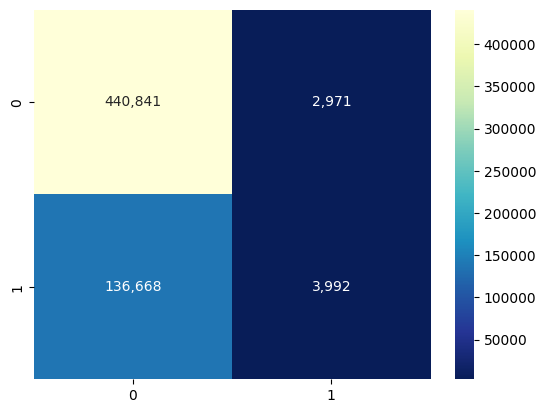

In [27]:
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=",.0f");

In [28]:
print('Weighted F1 score:',f1_score(y_test, y_pred, average='weighted'))

Weighted F1 score: 0.6685345121247476


In [30]:
TP = 3992
FN = 440841
FN = 136668
FP = 2971
precision = TP/(TP + FP) # asks what proportion of positive predictions are actually correct, i.e. what proportion of predicted 
                        # rejections are actually predicted correctly
recall = TP/(TP + FN) # aka TPR, sensitivity; asks what proportion of actual positives was predicted correctly, i.e.
                    # what proportion of actual rejections did we correctly predict as rejected.
f1_score = 2 * ((precision * recall)/(precision + recall))

print(f'precision: {precision*100:.3f}%')
print(f'recall: {recall*100:.3f}%')
print(f'f1: {f1_score*100:.3f}%')

precision: 57.332%
recall: 2.838%
f1: 5.408%


In [51]:
# save trained model
import pickle 
filename = '../models/xgboost_model_first.pickle' # PICK A FILE NAME, SHOULD END IN .pickle
pickle.dump(pipe, open(filename, "wb"))

In [22]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

### Remove cell/adjust target name as appropiate! 

In [17]:
# train test split
y = df.pop("claim_segmentation")
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [18]:
# run the training on a sample
X_train_samp = X_train.sample(frac=0.1, random_state=42)
y_train_samp = y_train[X_train_samp.index]

In [16]:
# define params for random search for 
rs_params={"clf__max_depth": list(np.arange(10, 100, step=10)) + [None],
           "clf__learning_rate": [0.01, 0.1, 0.2, 0.3],
           "clf__subsample": np.arange(0.5, 1.0, 0.1),
           "clf__colsample_bytree": np.arange(0.4, 1.0, 0.1),
           "clf__colsample_bylevel": np.arange(0.4, 1.0, 0.1),
           "clf__n_estimators": [100, 250, 500]}

In [17]:
# define randomized search
rand = RandomizedSearchCV(pipe, rs_params, n_iter=100, scoring="f1_weighted", cv=5, n_jobs=-1, random_state=42, verbose=5)

In [18]:
# run randomized search
rand.fit(X_train_samp, y_train_samp)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__max_depth=40, clf__n_estimators=100, clf__subsample=0.5;, score=0.725 total time= 1.8min
[CV 2/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__max_depth=40, clf__n_estimators=100, clf__subsample=0.5;, score=0.726 total time= 1.8min
[CV 5/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__max_depth=40, clf__n_estimators=100, clf__subsample=0.5;, score=0.728 total time= 1.8min
[CV 4/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__max_depth=40, clf__n_estimators=100, clf__subsample=0.5;, score=0.731 total time= 1.8min
[CV 1/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.6, clf__learning_rate=0.1, clf__max_depth=40, clf__n_

/Users/salilpachare/neuefische/florita/.venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.7999999999999999, clf__learning_rate=0.01, clf__max_depth=40, clf__n_estimators=250, clf__subsample=0.5;, score=0.718 total time=26.6min
[CV 1/5] END clf__colsample_bylevel=0.5, clf__colsample_bytree=0.7999999999999999, clf__learning_rate=0.1, clf__max_depth=80, clf__n_estimators=500, clf__subsample=0.5;, score=0.724 total time=45.9min
[CV 3/5] END clf__colsample_bylevel=0.7999999999999999, clf__colsample_bytree=0.7999999999999999, clf__learning_rate=0.01, clf__max_depth=40, clf__n_estimators=250, clf__subsample=0.5;, score=0.721 total time=41.9min
[CV 2/5] END clf__colsample_bylevel=0.5, clf__colsample_bytree=0.7999999999999999, clf__learning_rate=0.1, clf__max_depth=80, clf__n_estimators=500, clf__subsample=0.5;, score=0.727 total time=62.7min
[CV 3/5] END clf__colsample_bylevel=0.5, clf__colsample_bytree=0.7999999999999999, clf__learning_rate=0.1, clf__max_depth=80, clf__n_estimators=500, clf__subsample=

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['basementEnclosureCrawlspace',
                                                                                'policyCount',
                                                                                'elevatedBuildingIndicator',
                                                                                'elevationCertificateIndicator',
                                                                                'locationOfContents',
                                                                                'numberOfFloorsInTheInsuredBuilding',
                                                                                'n

In [19]:
# show best parameters
print("Best score:\n{:.2f}".format(rand.best_score_))
print("Best parameters:\n{}".format(rand.best_params_))

Best score:
0.73
Best parameters:
{'clf__subsample': 0.7999999999999999, 'clf__n_estimators': 250, 'clf__max_depth': 10, 'clf__learning_rate': 0.3, 'clf__colsample_bytree': 0.6, 'clf__colsample_bylevel': 0.5}


In [20]:
# create a results dataframe from the results dict of the classifier
result_df_rand = pd.DataFrame.from_dict(rand.cv_results_, orient="columns")
result_df_rand 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__subsample,param_clf__n_estimators,param_clf__max_depth,param_clf__learning_rate,param_clf__colsample_bytree,param_clf__colsample_bylevel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,101.011416,0.634093,6.148651,0.178754,0.5,100,40,0.1,0.6,0.8,"{'clf__subsample': 0.5, 'clf__n_estimators': 1...",0.726069,0.726386,0.724892,0.730549,0.728332,0.727246,0.001988,29
1,172.683797,10.129039,20.151585,0.692508,0.5,250,80,0.1,0.5,0.4,"{'clf__subsample': 0.5, 'clf__n_estimators': 2...",0.724810,0.725778,0.725584,0.728420,0.728344,0.726587,0.001501,38
2,32.944952,0.237734,0.710663,0.028106,0.5,250,None,0.3,0.6,0.5,"{'clf__subsample': 0.5, 'clf__n_estimators': 2...",0.720037,0.716709,0.716481,0.720958,0.717779,0.718393,0.001797,85
3,407.690856,3.779372,15.815749,0.475142,0.5,250,90,0.3,0.9,0.9,"{'clf__subsample': 0.5, 'clf__n_estimators': 2...",0.717965,0.722431,0.721889,0.723954,0.720140,0.721276,0.002056,74
4,278.317473,2.619483,20.823760,0.726463,0.9,250,80,0.3,0.5,0.7,"{'clf__subsample': 0.8999999999999999, 'clf__n...",0.726477,0.726465,0.726484,0.728520,0.726909,0.726971,0.000793,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,414.224768,1.923152,40.257981,1.123520,0.7,500,30,0.3,0.7,0.5,"{'clf__subsample': 0.7, 'clf__n_estimators': 5...",0.720852,0.722337,0.721443,0.724300,0.725436,0.722874,0.001734,71
96,275.293029,3.576791,19.811207,1.043506,0.6,250,80,0.3,0.9,0.4,"{'clf__subsample': 0.6, 'clf__n_estimators': 2...",0.719104,0.721680,0.718602,0.724489,0.721459,0.721067,0.002106,76
97,102.301149,2.208721,6.753177,0.968309,0.9,100,30,0.1,0.8,0.5,"{'clf__subsample': 0.8999999999999999, 'clf__n...",0.726067,0.725971,0.728092,0.731158,0.729939,0.728245,0.002064,11
98,721.214216,8.850461,43.430218,3.371440,0.8,500,90,0.1,0.6,0.9,"{'clf__subsample': 0.7999999999999999, 'clf__n...",0.727244,0.727968,0.726972,0.732527,0.729439,0.728830,0.002037,7


In [22]:
result_df_rand.to_csv("../data/random_search_results.csv")

In [ ]:
# define params for grid search, based on random search results
gs_params = {
            }

In [ ]:
# define grid search
grid = GridSearchCV(pipe, param_grid=gs_params, cv=5, scoring=f1_weighted, verbose=1, n_jobs=-1) #ftwo_scorer

In [ ]:
# run grid search
grid.fit(X_train, y_train)

In [ ]:
# show best parameters
print("Best score:\n{:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

In [ ]:
# save best model
best_model = grid.best_estimator_
filename = "finalized_model.sav"
pickle.dump(best_model, open(filename, "wb"))